# BioEn Spin-Label Enemble Refinement with DEER Data

By applying this ipython notebook, we can perform spin-label ensemble refinement with DEER data using BioEn. The steps of the Jupyter notebook are <br> 

1. Preparation of the input <br> 
2. BioEn <br> 
3. Analysis of the BioEn results<br> 

You can either use the provided test data or define your own protein of interest, use your own rotamer library, and define labeled position of interest.


### Theory and methods applied in this Jupyter notebook are available in:

K. Reichel, Lukas S. Stelzl, J. Köfinger, G. Hummer, “Precision DEER Distances from Spin-Label Reweighting“, J. Phys. Chem. Lett. (2018).

G. Hummer, J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

### Experimental DEER traced used in this Jupyter notebook are published in:
R. Dastvan, E. Brouwer, D. Schuetz, O. Mirus, E. Schleiff, T.F. Prisner, ”Relative orientation of POTRA domains from cyanobacterial Omp85 studied by pulsed EPR spectroscopy”, Biophys. J. 110, 2195--2206} (2016).

In [1]:
import numpy as np
import pickle
import pandas as pd

import MDAnalysis as mda
import MDAnalysis.analysis.align
import MDAnalysis.lib.NeighborSearch as KDNS
import MDAnalysis.analysis.distances

from scipy.special import fresnel

import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import bioen_rotamer as br

%matplotlib inline

## Define paths to the experimental and simulated data and for the output of preparation, BioEn, and analysis of the BioEn runs

In [2]:
%%capture
! mkdir files/output_preparation
! mkdir files/output_bioen
! mkdir files/output_analysis

# path to experimental data
path_experimental_data = "files/experimental_data/"

# path to simulated data
path_simulated_data = "files/simulated_data/"

# define path to the output of the preparation
path_output_preparation = "files/output_preparation"

# define path to the output of BioEn
path_output_bioen = "files/output_bioen"

# define path to the output of the analysis
path_output_analysis = "files/output_analysis"

# 1. Preparation

## Settings and input parameters for preparation

In [27]:
# use the protein of interest (here: crystal structure of the POTRA domains)
structure = "files/pdb_structure/3MC8_xray.pdb"

# pdb of the label (here: MTSL), trajectory and weights of the rotamer library
rotamer_library_pdb = "files/rotamer_library/rotamer1_R1A_298K_2015.pdb"
rotamer_library_dcd = "files/rotamer_library/rotamer1_R1A_298K_2015.dcd"
rotamer_library_weights = "files/rotamer_library/rotamer1_R1A_298K_weights_2015.dat"

# spin label positions to obtain rotamer states
spin_labels = [[370, 'C'], [292, 'A']]

# spin_label_pairs used for the spin-label reweighting
spin_label_pairs = [[[370, 'C'], [292, 'A']]]

# define clash_distance between atoms of the spin-spin label and the protein
clash_distance = 1.4

## Obtain for each labeled position a trajectory of spin-label rotamers

In [4]:
def get_rotamers():
    """
    Calculates for each spin-label position possible rotameric states
    according to the protein structure.
       
    Returns
    -------
    rotamer_labels: dict
        For each spin-label position an array with boolean entries 
        for each rotameric state
    """
    xray = mda.Universe(structure)
    rotamers = mda.Universe(rotamer_library_pdb, rotamer_library_dcd)

    rotamer_labels = dict()
    for label in spin_labels:
        resid = label[0]
        chainid = label[1]
        dcd_fn = '{}/tmp_traj_{}_{}.dcd'.format(path_output_preparation, resid, chainid)
        d = dict()
        br.fit_rotamers(rotamers, xray, resid, chainid, dcd_fn)
        rotamer_site = mda.Universe(rotamers.filename, dcd_fn)
        rotamer_clash = br.find_clashing_rotamers(clash_distance, rotamer_site, xray, resid, chainid)
        d['site'] = rotamer_site
        d['clash'] = rotamer_clash

        rotamer_nitrogen = rotamer_site.select_atoms("name N1")
        rotamer_oxygen = rotamer_site.select_atoms("name O1")
        rotamer_positions = dict()
        for rotamer in rotamer_site.trajectory:
             if not rotamer_clash[rotamer.frame]:
                rotamer_electron = (np.array(rotamer_nitrogen.positions[0][0:3]) + np.asarray(rotamer_oxygen.positions[0][0:3]))/2.0
                rotamer_positions[rotamer.frame] = [rotamer_electron]
        d['positions'] = rotamer_positions
        ln = '{}-{}'.format(resid, chainid)
        rotamer_labels[ln] = d
    return rotamer_labels

In [5]:
rotamer_labels = get_rotamers()

Step   216/216 [100.0%]
Step   216/216 [100.0%]


## Get for each spin-label distance in the rotamer trajectories a single DEER trace

In [6]:
def get_preparation_output(rotamer_labels, rotamer_library_weights, path_output_preparation):
    """
    Generates all needed input files for BioEn 
        data_*.pkl --> DEER traces based on spin-label distances
        models_*.dat --> list of the model ids
        frames_*.pkl --> spin-label rotamers and spin-label distances
    """   
    for spin_label_pair in spin_label_pairs:
        label_pair_id = [spin_label_pair[0][0], spin_label_pair[1][0]]
        ts = br.get_experimental_timesteps(path_experimental_data, label_pair_id)
        spin_label_pair.append(ts)
        br.get_deer_from_single_pair(spin_label_pair, rotamer_labels, rotamer_library_weights, path_output_preparation)    
    return

In [7]:
get_preparation_output(rotamer_labels, rotamer_library_weights, path_output_preparation)

Generated files are saved in files/output_preparation:
	data_370-292.pkl --> DEER traces based on spin-label distances
	models_370-292.dat --> list of the model ids
	frames_370-292.pkl --> spin-label rotamers and spin-label distances


# BioEn

## Settings and input parameters for BioEn

In [8]:
# define theta series, bioen performs for each theta reweighting
theta_series = [10e5, 10e4, 10e3, 10e2, 10e1, 10e0, 10e-1, 0]
np.savetxt('theta.dat', np.array(theta_series))

## Run BioEn with bash script and use files generated in the preparation

In [9]:
def run_bioen_script(label_pair_id, nmodels):
    ! bash run_bioen_ipynb_deer.sh $label_pair_id $nmodels 
    return

In [10]:
#%%capture c
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    
    #get number of ensemble members = nmodels
    nmodels = len(np.loadtxt('{}/models_{}.dat'.format(path_output_preparation, label_pair_id)))          
    # start BioEn reweighting for each spin-label pair
    run_bioen_script(label_pair_id, nmodels)

INFO:root:BioEn weight refinement starts with
INFO:root:    optimization method: log-weights
INFO:root:    optimization algorithm: bfgs
INFO:root:    optimization minimizer: GSL
INFO:root:BioEn finished weight refinement in 748.97 s.


# Analysis

## Settings and input parameters for analysis of BioEn outputs

In [11]:
def load_bioen_pkl(label_pair_id):
    """
    Loads output of BioEn pkl file (contains all information)
    """
    df = pd.read_pickle("{}/bioen_{}.pkl".format(path_output_bioen, label_pair_id))
    return df.to_dict()

In [12]:
def get_frames(label_pair_id):
    """
    Loads frames file (contains information on rotamer states and distances)
    """
    frames_pkl = '{}/frames_{}.pkl'.format(path_output_preparation, label_pair_id)
    with open(frames_pkl, 'r') as file:
        [frames_dict] = pickle.load(file)
    return frames_dict

In [13]:
bioen_data_all = dict()
frames_data_all = dict()
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    bioen_data_all[label_pair_id] = load_bioen_pkl(label_pair_id)
    frames_data_all[label_pair_id] = get_frames(label_pair_id)

`bioen_data` contains all needed and useful information to analyse the BioEn calculations. <br>
For each previously defined confidence value $\theta$ (defined in the variable `theta_series`) a list of BioEn output is available:

**Experimental information**
- **`exp`** <br> 
--> experimental DEER signals for each label <br>
--> in case of DEER data, this variable contains time, DEER signal and polynomial fit of the DEER signal <br>
--> time: `data['exp']['370-292'][:,0]` <br>
--> DEER trace: `data['exp']['370-292'][:,1]` <br>
--> polynomial fit of DEER trace: `data['exp']['370-292'][:,1]` <br>
- **`exp_err`** <br>
--> error/noise of each experimental data point defined in `exp`
- **`labels`** <br> 
--> list of labels used in the refinement
- **`nrestraints`** <br>
--> number of data points ($M$)

**Simulated data and parameters**
- **`sim_init`** <br> 
--> initial ensemble averaged simulated DEER traces for each label (see above for exp)
- **`sim_wopt`** <br>
--> optimized ensemble averaged simulated DEER traces for each label and for a given confidence value $\theta$
- **`moddepth`** <br>
--> modulation depth of the optimized ensemble averaged simulated DEER traces for each label 
- **`nmodels_list`** <br>
--> list of model ids (extracted e.g. from models_370-292.dat)
- **`nmodels`** <br>
--> number of models ($N$), which is also the number of ensemble members (relevant in the BioEn context) <br>
--> `nmodels` = `nrotamers` <br>
--> number of rotamers, which is needed to backcalculate weights of rotamers of a spin-label position (relevant in the analysis contex) <br>

**Free energy parameters**
- **`theta`** <br>
--> confidence parameter $\theta$
- **`chi2_init`** <br>
--> deviation from the experimental data with the initial weight distribution <br>
--> if you use `chi2_init` of the maximal value of $\theta$, $\chi^2$ is calculated with the prior weight distribution `w0`
- **`chi2`** <br>
--> optimal $\chi^2$ calculated with optimal weight distribution `wopt`
- **`S_init`** <br>
--> initial relative entropy
--> if you use `S_init` of the maximal value of $\theta$, $S$ is equal to $0$
- **`S`** <br>
--> relative entropy of optimized weight distribution
- **`w0`** <br>
--> reference weight distribution
- **`winit`** <br>
--> initial weight distribution
- **`wopt`** <br>
--> optimal weight distribution <br>
--> optimized for each $\theta$

**Misc**
- **`len_sim`** <br>
--> seconds it took for BioEn to optimize for a given value of $\theta$
- **`optimization_method`** <br>
--> information about the optimization method: log-weights or forces
- **`optimization_minimizer`** <br>
--> information about the minimer: scipy, GSL, LBFGS
- **`optimization_algorithm`** <br>
--> information about the inimizer: <br>
--> scipy: bfgs, lbfgs, cg <br>
--> GSL: conjugate_fr, conjugate_pr, bfgs, bfgs, steepest_descent<br>
--> LBFGS: lbfgs <br>

### Plot $\chi^{2} vs. S_{\mathrm{KL}}$

the lower $\theta$, the closer to experimental data

In [14]:
def visualize_chi2_skl(bioen_data, label_pair_id):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    for theta in theta_series:
        chi2 = bioen_data[theta]['chi2'] / bioen_data[theta]['nrestraints']
        skl = - bioen_data[theta]['S']
        ax.scatter(skl, chi2, marker='^', s=160, label=theta)  
    
    ax.set_xticks(range(-1,6,1))   
    ax.set_xticklabels(range(-1,6,1), fontsize=fs)
    ax.set_xlim(-0.4,5.5)
    ax.set_xlabel(r'$S_{\mathrm{KL}}$', fontsize=fs)

    ax.set_yticks(np.arange(0,10,1))   
    ax.set_yticklabels(np.arange(0,10,1), fontsize=fs)
    ax.set_ylim(-0.2, 4)
    ax.set_ylabel(r'$\chi^{2}$', fontsize=fs)    
    
    plt.grid()
    
    ax.legend(ncol=2, fontsize=10)
    
    plt.tight_layout()
    plt.savefig("{}/bioen_chi2_skl_{}.png".format(path_output_analysis, label_pair_id), dpi=400)
    plt.show()
    return

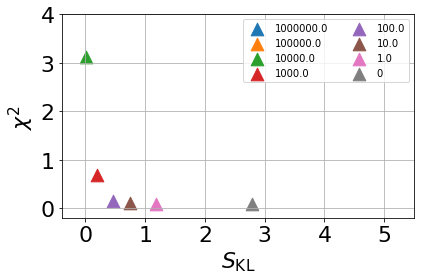

In [15]:
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    visualize_chi2_skl(bioen_data_all[label_pair_id], label_pair_id)

## Comparison experimental and weighted ensemble averaged DEER traces

In [16]:
def visualize_deer_traces(theta, bioen_data, label_pair_id):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    theta_max = np.max(bioen_data.keys())
    
    label = bioen_data[theta]['exp']['deer'].keys()[0]
    exp = bioen_data[theta]['exp']['deer'][label]
    exp_err = bioen_data[theta]['exp_err']['deer'][label]
    
    sim_init = bioen_data[theta_max]['sim_init']['deer'][label]
    sim = bioen_data[theta]['sim_wopt']['deer'][label]
    
    ax.plot(exp[:,0], exp[:,1], color='black', linewidth=2.5, label='Exp.',zorder=2)
    ax.fill_between(exp[:,0], exp[:,2]-exp_err, exp[:,2]+exp_err, color='black', alpha=0.2, label='Error', linewidth=1.0, zorder=1)
    ax.plot(exp[:,0], sim_init, color='green', linewidth=3.0, label=r"X-ray",zorder=0)
    ax.plot(exp[:,0], sim, color='red', linewidth=3.0, label=r"BioEn".format(theta),zorder=3)
    
    ax.set_xticks(np.arange(0,4.0,1.0))
    ax.set_xticklabels(np.arange(0,4.0,1.0), fontsize=fs)
    ax.set_xlim(0,3.5)
    ax.set_xlabel(r't [$\mu$s]', fontsize=fs+2)

    ax.set_yticks(np.arange(-0.6,1.4,0.2))
    ax.set_yticklabels(np.arange(-0.6,1.4,0.2), fontsize=fs)
    ax.set_ylim(0.35,1.0)
    ax.set_ylabel(r'F(t)', fontsize=fs)

    ax.legend(loc=1, ncol=2, fontsize=10)
    
    plt.grid()
    
    plt.tight_layout()
    plt.savefig("{}/bioen_deer_{}.png".format(path_output_analysis,label_pair_id), dpi=400)
    plt.show()
    return

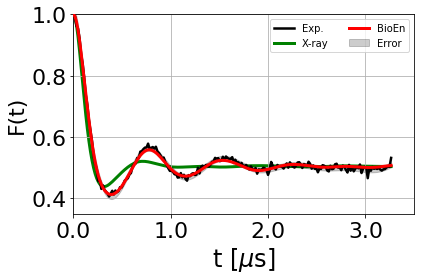

In [17]:
theta = 100.0
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    visualize_deer_traces(theta, bioen_data_all[label_pair_id], label_pair_id)

## Cummulative weight

In [18]:
def visualize_cum_dist(theta, bioen_data, label_pair_id):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    nmodels = bioen_data[theta]["nmodels"]
    a = np.vstack((bioen_data[theta]["nmodels_list"], np.array(bioen_data[theta]["wopt"]).reshape(1,-1)))
    
    models = []
    for i, id in enumerate(np.argsort(a[1,:])[::-1]):
        if i == 0: models.append([a[:,id][0], float(a[:,id][1]), float(a[:,id][1])])
        else: models.append([a[:,id][0], float(a[:,id][1]), models[-1][2]+float(a[:,id][1])])

    models = np.array(models)
    ax.scatter(range(1,nmodels+1), models[:,2], s=20, color='green', zorder=2)
    ax.plot(range(1,nmodels+1), models[:,2], color='black', zorder=1)

    ax.set_xticks([0.0, 10.0, 100.0, 1000.0, 10000.0])
    ax.set_xticklabels([r'$10^{0}$', r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'], fontsize=fs)
    ax.set_xlabel("Fraction of configurations", fontsize=fs)
    ax.semilogx()
    ax.set_yticklabels(np.arange(0,1.2,0.2), fontsize=fs)
    ax.set_ylim(0,1)
    ax.set_ylabel("Cumulative distribution", fontsize=fs)
    
    ax.grid()
    
    plt.savefig('{}/bioen_cum_weights_{}.png'.format(path_output_analysis, label_pair_id), dpi=600, bbox_inches='tight')
    return

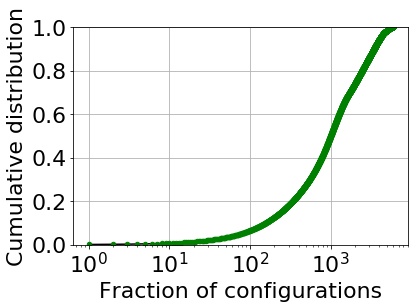

In [19]:
theta = 100.0
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    visualize_cum_dist(theta, bioen_data_all[label_pair_id], label_pair_id)

## Distance distribution

### Obtain distances based on the weights from the BioEn calculation and frames*pkl

In [20]:
def get_distances(bioen_data, frames_data, theta):
    nmodels = bioen_data[theta]["nmodels"]
    weights = np.array(bioen_data[theta]["wopt"])
    nmodels_weights = (np.vstack((bioen_data[theta]["nmodels_list"], 
                       np.array(bioen_data[theta]["wopt"]).reshape(1,-1)))).T
    weights_distances = []
    for model in nmodels_weights:
        weights_distances.append([frames_data[model[0]]['dist'], model[1]])
    return np.array(weights_distances)

In [21]:
theta = 100.0
weights_distances_all = dict()
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    weights_distances_all[label_pair_id] = get_distances(bioen_data_all[label_pair_id], 
                                                   frames_data_all[label_pair_id], theta)

### Visulize distances with prior and optimized weights

In [22]:
def visualize_dist_distr(weights_distances):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    distances = weights_distances[:,0]
    weights = weights_distances[:,1]
    
    ax.axes.hist(distances, bins=100, color='green', label="X-ray (w0)", alpha=0.2, zorder=2, normed=True)
    ax.axes.hist(distances, bins=100, color='green', alpha=0.8, zorder=2, normed=True, histtype='step')
    ax.axes.hist(distances, weights=weights, bins=100, color='red', label=r"Shift (wopt, $\theta=10^3$)", alpha=0.2, normed=True,)
    ax.axes.hist(distances, weights=weights, bins=100, color='red', alpha=0.8, normed=True, histtype='step')
    
    ax.set_xticks(range(0,80,10))
    ax.set_xticklabels(range(0,80,10), fontsize=fs)
    ax.set_xlim(15, 60)
    ax.set_xlabel(r'r [nm]', fontsize=fs)

    ax.set_yticklabels([], fontsize=fs)
    ax.set_ylabel(r'P(r)', fontsize=fs)    
    
    plt.grid(zorder=3)
    
    plt.savefig('{}/bioen_dist_distr_370-A_292-C.png'.format(path_output_analysis), dpi=600, bbox_inches='tight')
    
    return

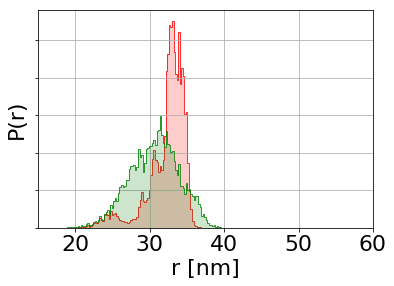

In [23]:
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    visualize_dist_distr(weights_distances_all[label_pair_id])

## Rotamer distribution of spin-label positions

### Calculate rotamer distribution

In [24]:
rotamer_weights_all = dict()
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    rotamer_weights = dict()
    for label_id in [spin_label_pair[0][0], spin_label_pair[1][0]]:
        rotamer_weights[label_id] = br.get_weighted_rotamer_states(frames_data_all[label_pair_id], 
                                                                   bioen_data_all[label_pair_id], 
                                                                   label_id, theta=1000.0)
    rotamer_weights_all[label_pair_id] = rotamer_weights

### Write pdbs 
- with the rotamer states (position of the unpaired electron between the nitroxidide N and O)
- the cummulative weight of that rotamer states as the B-factor

In [25]:
def write_rotamer_pdb(label_pair_id, label_id_chain, label_id):
    rotamer_positions = rotamer_labels[label_id_chain]["positions"]
    rotamer_pdb = "{}/weighted_rotamers_{}_{}.pdb".format(path_output_analysis, label_pair_id, label_id)
    pdb = open(rotamer_pdb, 'w')

    w_check = []
    for frame, weights in rotamer_weights_all[label_pair_id][label_id].iteritems():
        w_check.append(np.sum(weights))
        x = rotamer_positions[frame][0][0]
        y = rotamer_positions[frame][0][1]
        z = rotamer_positions[frame][0][2]
        line =  "ATOM   {:4d}  O   ALA A{:4d}    {:8.3f}{:8.3f}{:8.3f}     {:6.8f}     \n".format(int(frame), 
                                                                                                  int(frame), 
                                                                                                  x, y, z, 
                                                                                                  np.sum(weights))
        pdb.write(line)
    pdb.close()
    
    print 'Find the pdb in \'{}\'.'.format(path_output_analysis)
    return

In [28]:
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    for slp_id in spin_label_pair[0:2]:
        label_id_chain = '{}-{}'.format(slp_id[0], slp_id[1])
        label_id = slp_id[0]
        write_rotamer_pdb(label_pair_id, label_id_chain, label_id)

Find the pdb in 'files/output_analysis'.
Find the pdb in 'files/output_analysis'.
